# Predicción del cancer de prostata 

#### Datos

Consideramos un estudio médico realizado en 97 hombres con cáncer de próstata. La atención se centra en la relación entre el antígeno prostático específico (psa), que está elevado en hombres con cáncer de próstata, y otras medidas clínicas. Las otras medidas clínicas son las variables predictoras, recogidas en un examen médico, y la cantidad de representación del antígeno asociado a la detección del cáncer es la variable respuesta (lpsa).

Así, el *dataframe* está formado por 97 observaciones y 9 variables:
* lcavol: logaritmo del volumen del cáncer
* lweight: logaritmo del peso de la próstata
* edad: edad del paciente en años
* lbph: cantidad logarítmica de hiperplasia prostática benigna
* svi: invasión de vesículas seminales
* lcp: registro de penetración capsular
* gleason: puntuación de Gleason
* pgg45: porcentaje de puntuación de Gleason 4 o 5
* lpsa: logaritmo de antígeno prostático específico

El objetivo es encontrar modelos que realicen la predicción del valor de lpsa.

#### Modelos

Los datos están representados por $n$ puntos en $p$ dimensiones, por lo tanto la variable predictora se escribe $X\in\mathbb{R}^{n\times p}$ y la variable de respuesta es $y\in\mathbb{ R}^n$.

En este trabajo, estamos interesados en la relación entre el predictor $X$ y la respuesta $y$. Para determinar esta relación, adoptamos modelos de regresión. La línea de base estándar se logra con regresión lineal y comparamos los resultados de regresiones regularizadas: **regresión *Ridge****, ***Lasso*** y ***Elastic Net***.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns

## Exploración de datos

In [2]:
lpsa_data = pd.read_csv('data/prostate_dataset.txt', delimiter='\t')
lpsa_data = lpsa_data.loc[:, 'lcavol':]
lpsa_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


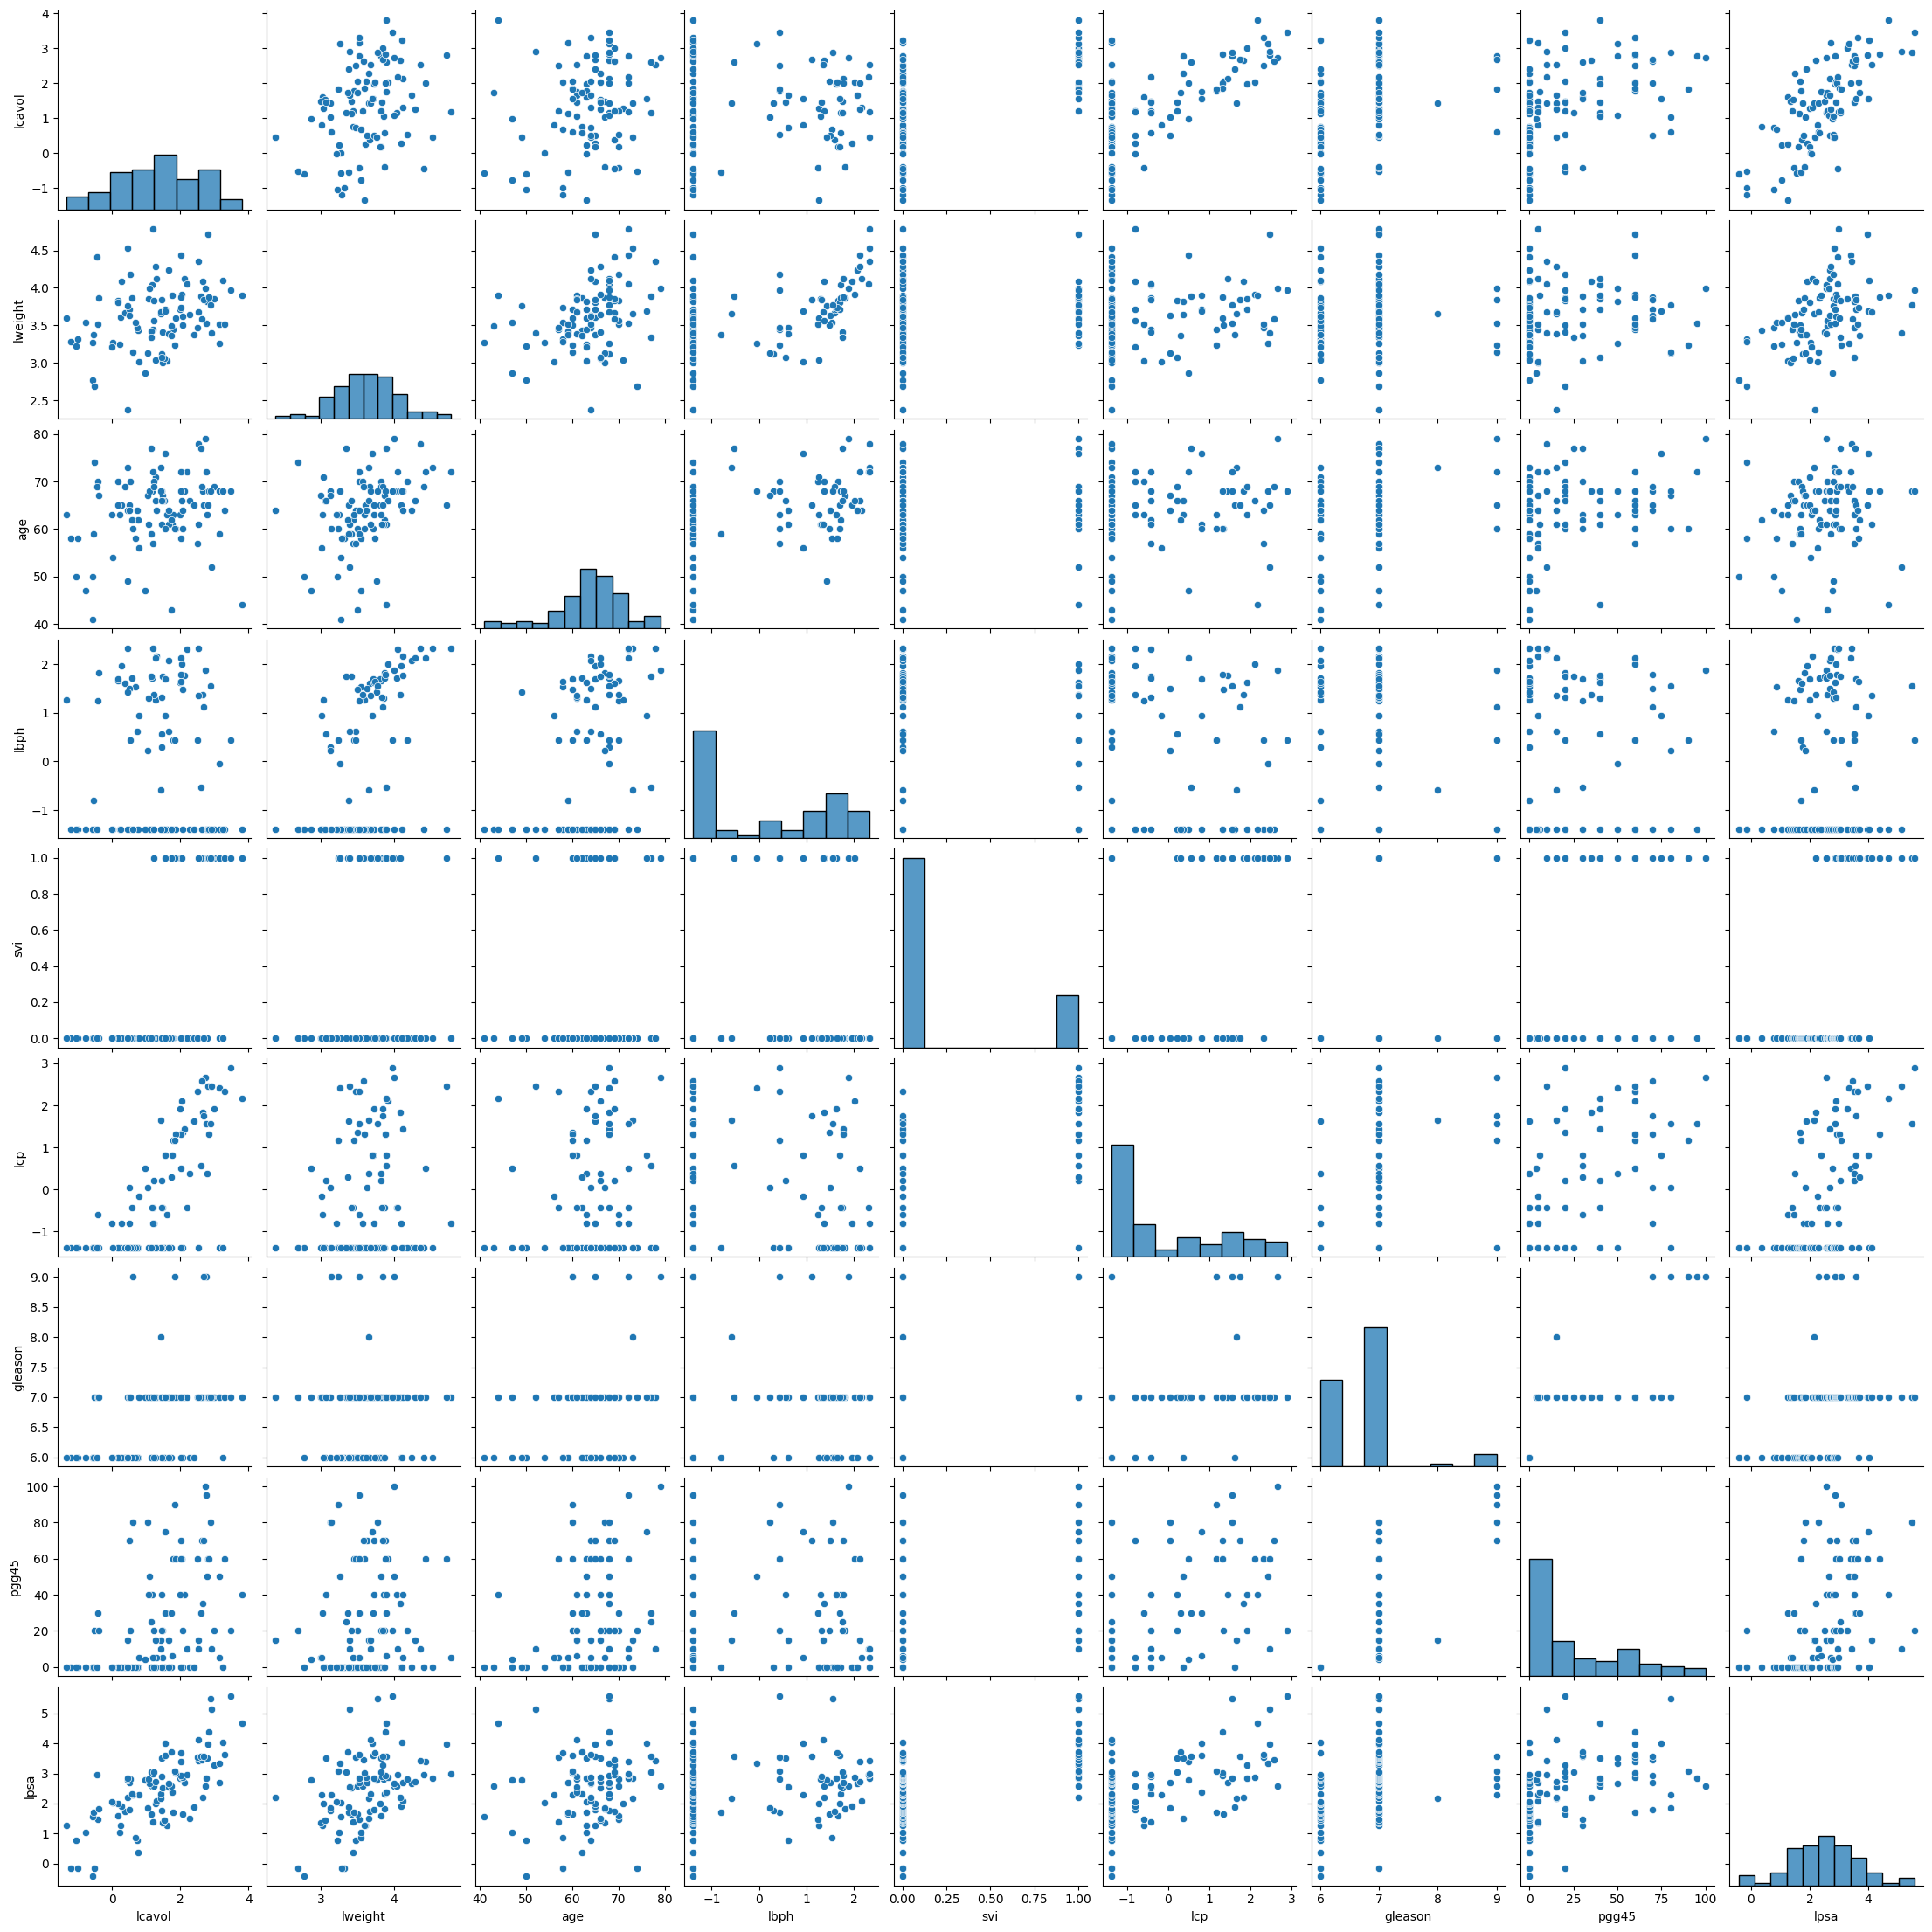

In [3]:
sns.pairplot(lpsa_data);

* lspa tiene una distribución casi normal.
* la presencia de svi es binaria
* lcp: debido a mediciones incorrectas, para valores pequeños de penetración capsular, se ha fijado arbitrariamente en -1,25.
* gleason y pgg45 no parecen estar correlacionados...

Veamos la correlación entre variables.

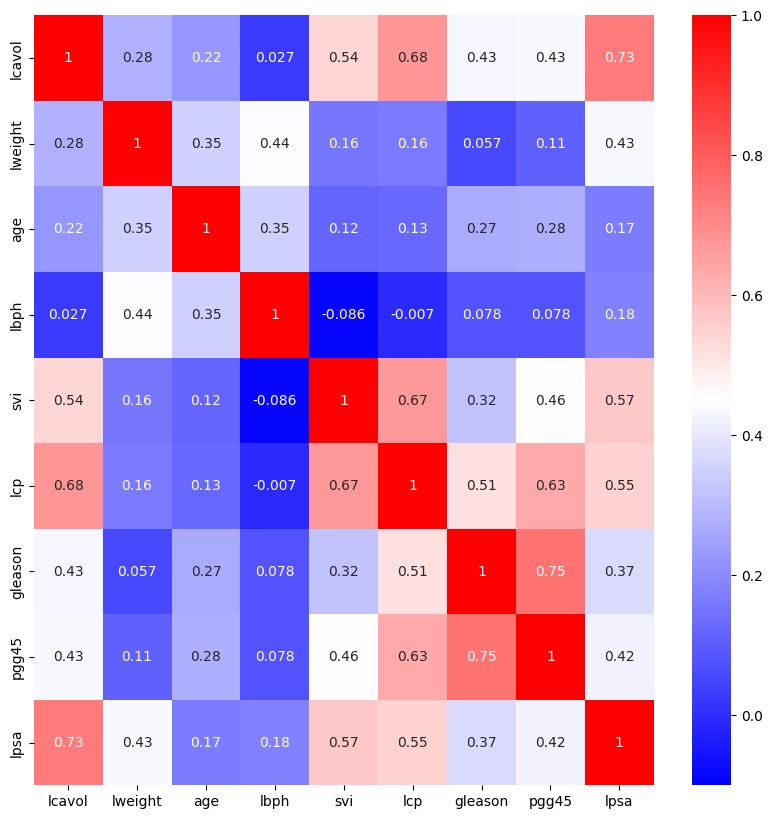

In [6]:
#### CODE
# sns.diverging_palette(145, 280, s=85, l=25, n=7)
plt.figure(figsize=(10,10))
sns.heatmap(lpsa_data.corr(),
           vmin=-0.1,
           vmax=1,
           #cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True,
           cmap="bwr");

* La variable más correlacionada con la variable objetivo lpsa es lcavol. Por tanto, en un análisis de datos, la variable lcavol debe incluirse como predictor.

* La matriz de correlación muestra que gleason y pgg45 en realidad están correlacionados. De hecho, la variable pgg45 mide el porcentaje de 4 o 5 puntuaciones de Gleason que se registraron antes de la puntuación de Gleason actual final.

Tracemos la relación entre la respuesta lpsa y la variable explicativa (predictora) lcavol.

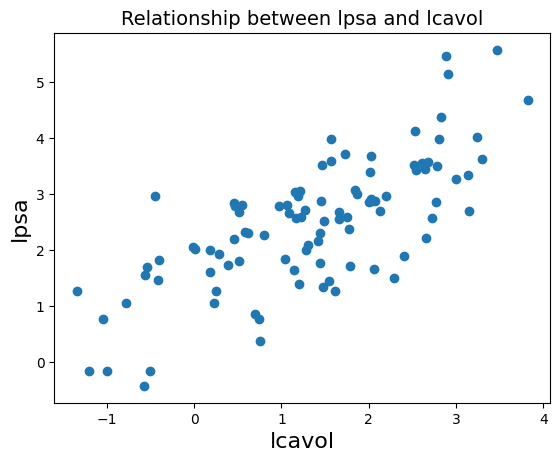

In [7]:
plt.scatter(lpsa_data['lcavol'], lpsa_data['lpsa'])
plt.xlabel('lcavol', fontsize=16)
plt.ylabel('lpsa', fontsize=16)
plt.title("Relationship between lpsa and lcavol", fontsize=14)
plt.show()

Existe una relación lineal bastante clara con correlación positiva, como se ve en la matriz de correlación.

### Train-Test

In [8]:
lpsa_data.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


In [9]:
# train : the first rows 
# test : the last rows 
n_split = 60
X_train = lpsa_data.iloc[:n_split,0:-2] # without pgg45
X_test = lpsa_data.iloc[n_split:,0:-2]
y_train = lpsa_data.iloc[:n_split,-1] # lpsa column
y_test = lpsa_data.iloc[n_split:,-1]  # lpsa column

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 7)
(37, 7)
(60,)
(37,)


# Algoritmos de aprendizaje


# 1) Regresión lineal (*baseline*)

La regresión lineal intenta modelar la relación entre las variables predictoras $X$ y la variable de respuesta $y$.
Consiste en encontrar una función lineal $f:\mathbb{R}^p \to \mathbb{R}$ que prediga la respuesta $y_i$ a partir de los predictores $X_{i1},...,X_{ip}$ dadas $n$ observaciones para $i=1,...,n$.

En Python, la regresión lineal se implementa como [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) en el módulo linear_model de scikit-learn.

In [11]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 0.2877748864599949
Test MSE: 2.8641499657014418


# 2) Regularización

Para evitar el sobreajuste, el método de regularización permite controlar la complejidad del modelo.
El modelo minimiza el error más un término de regularización $\lambda Reg(\beta)$ que mide la complejidad, donde $Reg(\beta)$ es un término de penalización y $\lambda$ es un hiperparámetro.
El hiperparámetro controla la influencia relativa del término de error y la cantidad de regularización.
El valor óptimo de $\lambda$ se puede encontrar mediante validación cruzada (consulte el repositorio [validación cruzada](https://github.com/christelle-git/cross-validation/)).

## 2.1) Regresión *Ridge* 

En la regresión *Ridge*, el término de regularización es $Reg(\beta) = ||\beta||_2^2$.
La regresión *Ridge* permite reducir la magnitud de los pesos $\beta_i$ de la regresión lineal, y así evitar el sobreajuste.
La regresión *Ridge* tiene un efecto de selección agrupada: las variables correlacionadas tienen los mismos pesos.

In [12]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha = 10) #alpha: coeficinte que multiplica el sumatorio
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),2))
print("Test MSE:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),2))
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, ridgeR.predict(X_test))))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE: 0.32
Test MSE: 2.07


In [15]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) #generamos una secuencia de valores
np.min(alphas)


0.0001

In [16]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

Error mas pequeño:

In [17]:
min(err_ridge)

2.0650575013210712

Valor optimo de alpha para el error mas pequeño:

In [27]:
alphas[err_ridge.index(min(err_ridge))]

8.902150854450374

Siguiente grafica interesante para ver los errores.

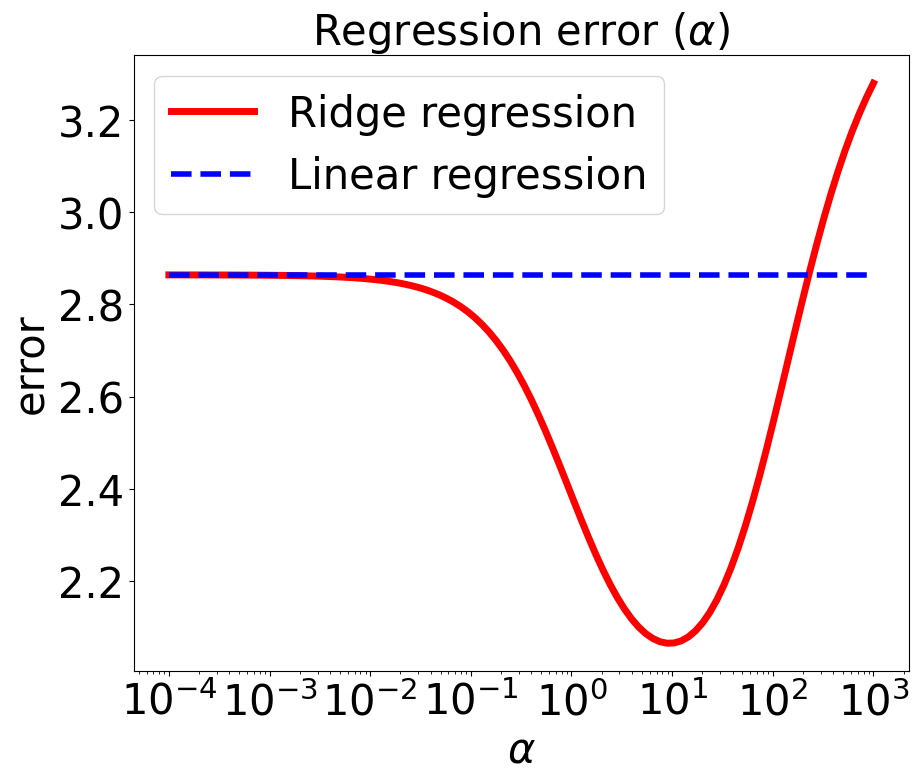

In [24]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\\alpha$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha$)', fontsize=30)
plt.show()

In [25]:
from sklearn.linear_model import Ridge 
  
# Train the model  
ridgeR = Ridge(alpha = 10) 
ridgeR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, ridgeR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, ridgeR.predict(X_test)))

Train MSE: 0.3160
Test MSE: 2.0651


* El valor óptimo del coeficiente de regularización $\lambda$ es alrededor de 10.
* Para $\lambda \to 0$, los términos de regularización desaparecen, lo que lleva al mismo resultado que la regresión lineal.
* Para $\lambda \to \infty$ domina el término de regularización.

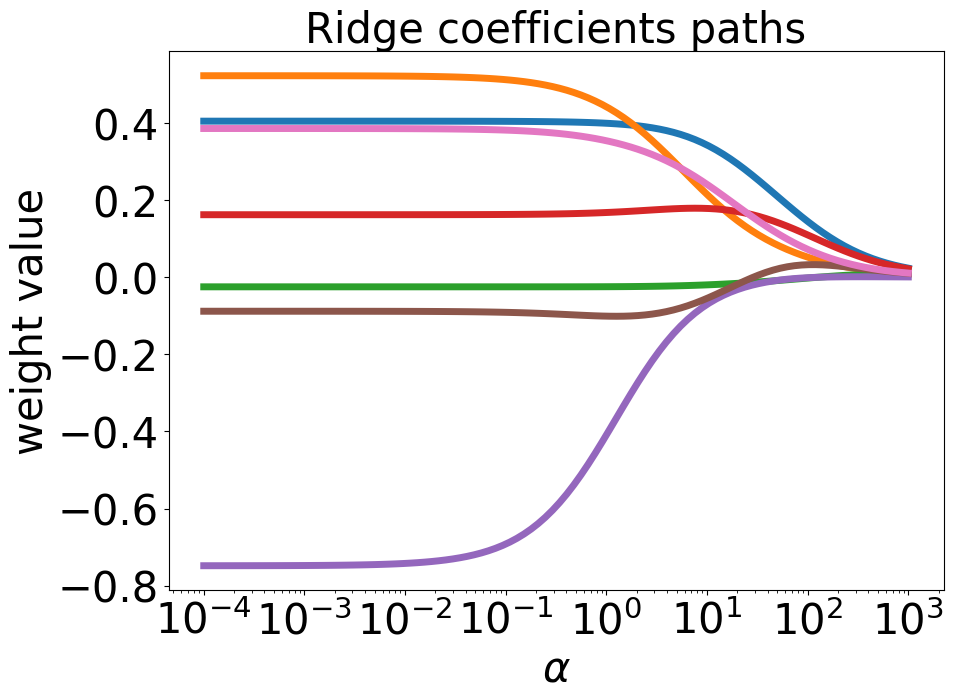

In [29]:
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\\alpha$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

#cada linea es una de las variables del dataset


* La regresión *Ridge* restringe algunas variables al reducir la magnitud de sus pesos.

## 2.2) Operador de selección y contracción mínima absoluta (*Least Absolute Shrinkage and Selection Operator*)

El siguiente método va más allá al seleccionar algunas variables que se eliminarán de la regresión *Ridge*, reduciendo así la dimensión.
El método se llama *Least Absolute Shrinkage and Selection Operator* (*Lasso*) y el modelo simplificado resultante es un **modelo disperso** o modelo parsimonioso.
En *Lasso*, el término de regularización se define por $Reg(\beta) = ||\beta||_1$.

*Lasso* realiza la selección de características de un modelo: para las variables correlacionadas, retiene solo una variable y establece las otras variables correlacionadas en cero.
La contraparte es que obviamente induce una pérdida de información que resulta en una menor precisión.

In [30]:
from sklearn.linear_model import Lasso

lassoR = Lasso(alpha=0.1)
lassoR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE: 0.3740
Test MSE: 2.0788


In [31]:
lasso = linear_model.Lasso(fit_intercept=False)

coef_lasso = []
err_lasso = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)    
    err_lasso.append(lasso_error)

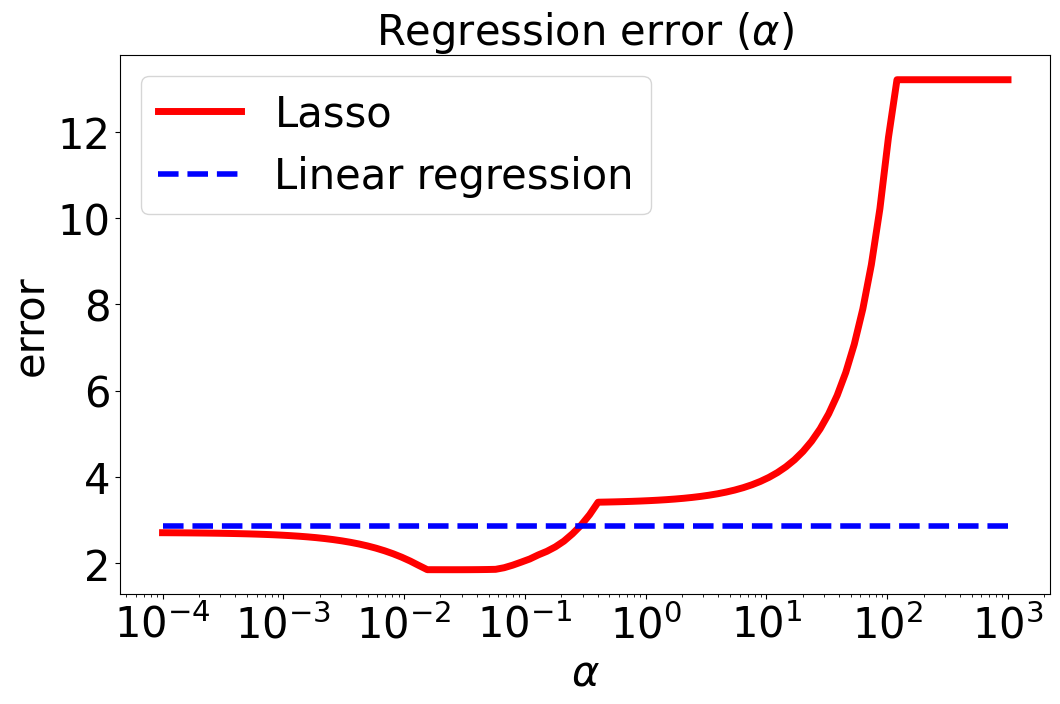

In [35]:
plt.figure(figsize=(12,7))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\\alpha$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha$)', fontsize=30)
plt.show()

In [36]:
lassoR = Lasso(alpha = 0.02) 
lassoR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


In [37]:
print("Test MAPE: %0.4f" % metrics.mean_absolute_percentage_error(y_test, lassoR.predict(X_test)))

Test MAPE: 0.3103


* El valor óptimo del coeficiente de regularización $\lambda$ está entre $10^{-2}$ y $10^{-1}$.
* Para $\lambda \to 0$ los términos de regularización desaparecen, por lo que la regresión de *Lasso* tiende a la regresión lineal.
* Para $\lambda \to \infty$ la magnitud del término de regularización domina el error.

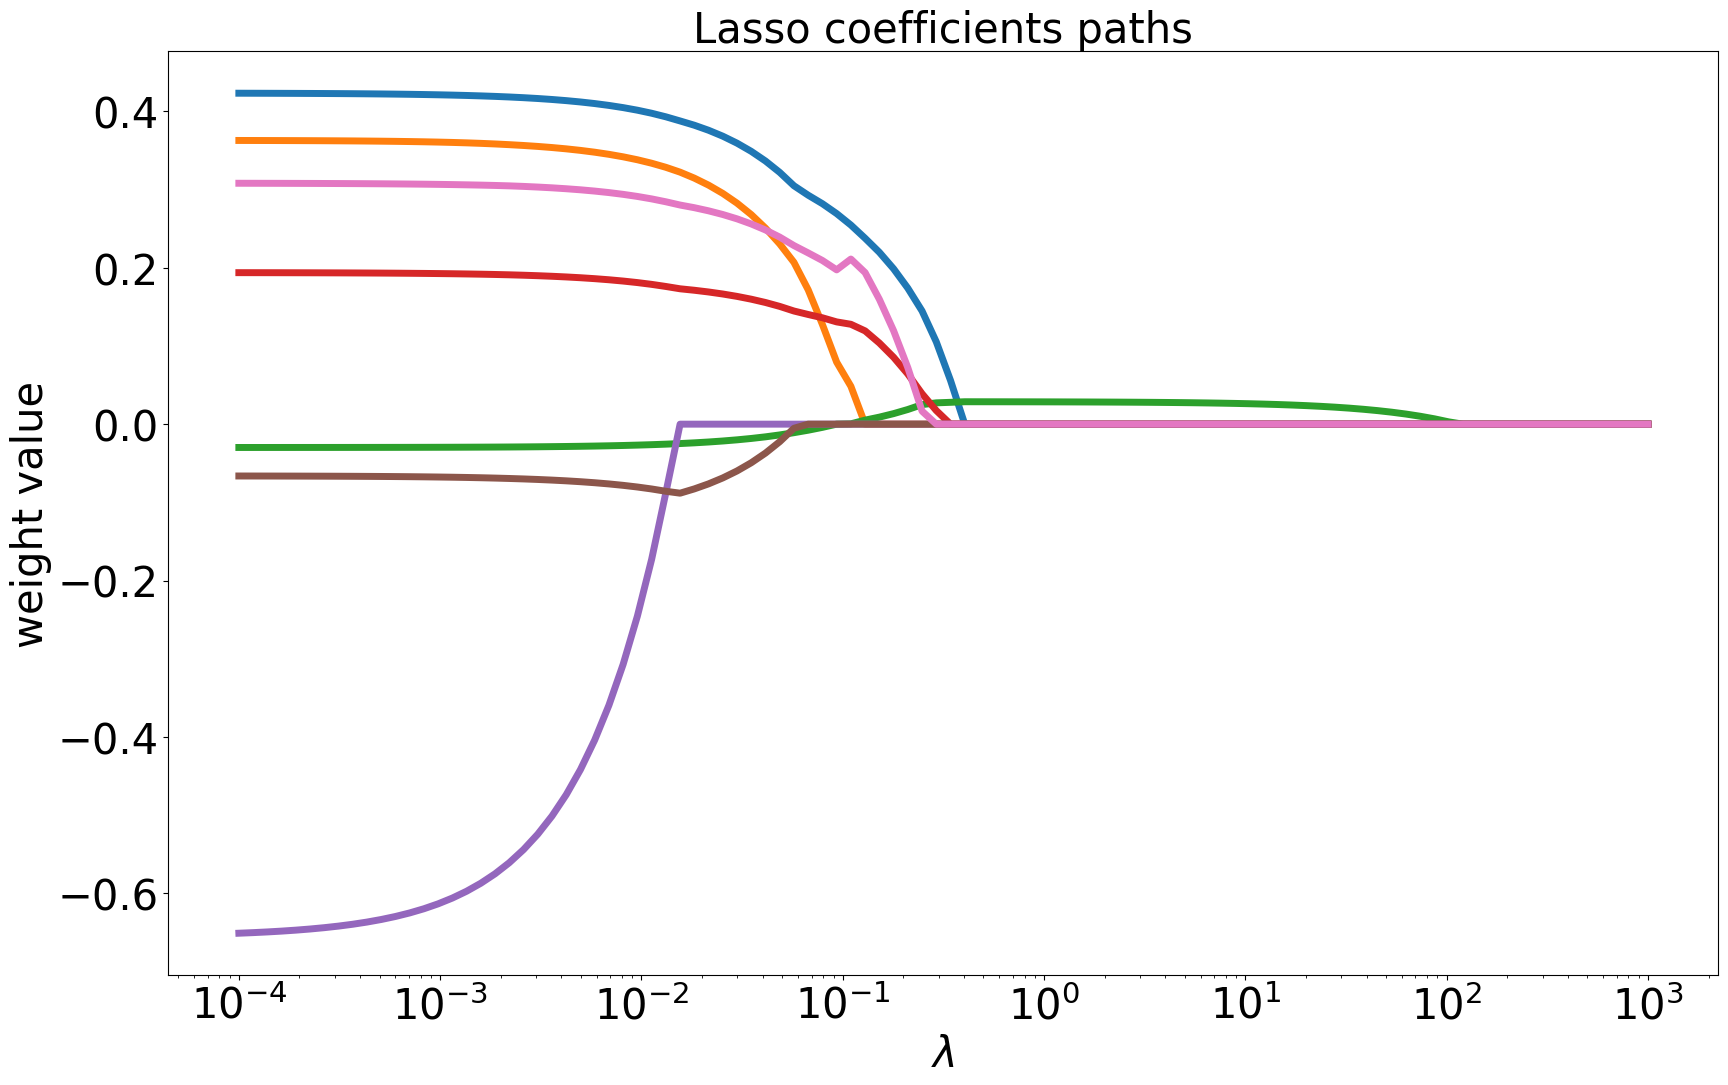

In [38]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

* El algoritmo *Lasso* elimina algunas variables poniendo su peso a cero.<br>
   Este es el caso si dos variables están correlacionadas.
* A medida que los pesos $\lambda \to \infty$ desaparecen, el modelo se vuelve muy disperso.

## 2.3) *Elastic net*

El método *Elastic Net* es un algoritmo híbrido de la regresión *Ridge* y el *Lasso*, por lo que supera el problema de la pérdida de información.
El término de regularización combina las regularizaciones $L_1$ y $L_2$.
Más precisamente, el término de regularización se establece en $Reg(\beta) = \lambda((1-\alpha)||\beta||_1+\alpha||\beta||_2^2)$ donde $\alpha$ es un parámetro adicional para ajustar.

El algoritmo *Elastic Net* tiene un efecto de selección de variables como *Lasso* pero mantiene las variables correlacionadas como regresión *Ridge*.
Por tanto, el modelo de *Elastic Net* es menos escaso que el *Lasso* y conserva más información.
Sin embargo el modelo es más exigente en recursos computacionales.

A continuación presentamos resultados para $\alpha=0.5$.

In [39]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
elastic_net.fit(X_train, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.6375
Test MSE: 3.5183


In [40]:
np.random.randint(0,1,100)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
coef_eln = []
err_eln = []
baseline = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=0.5)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    err_eln.append(elasticnet_error)
    baseline.append(baseline_error)
    

In [42]:
min(err_eln)

1.851230485072897

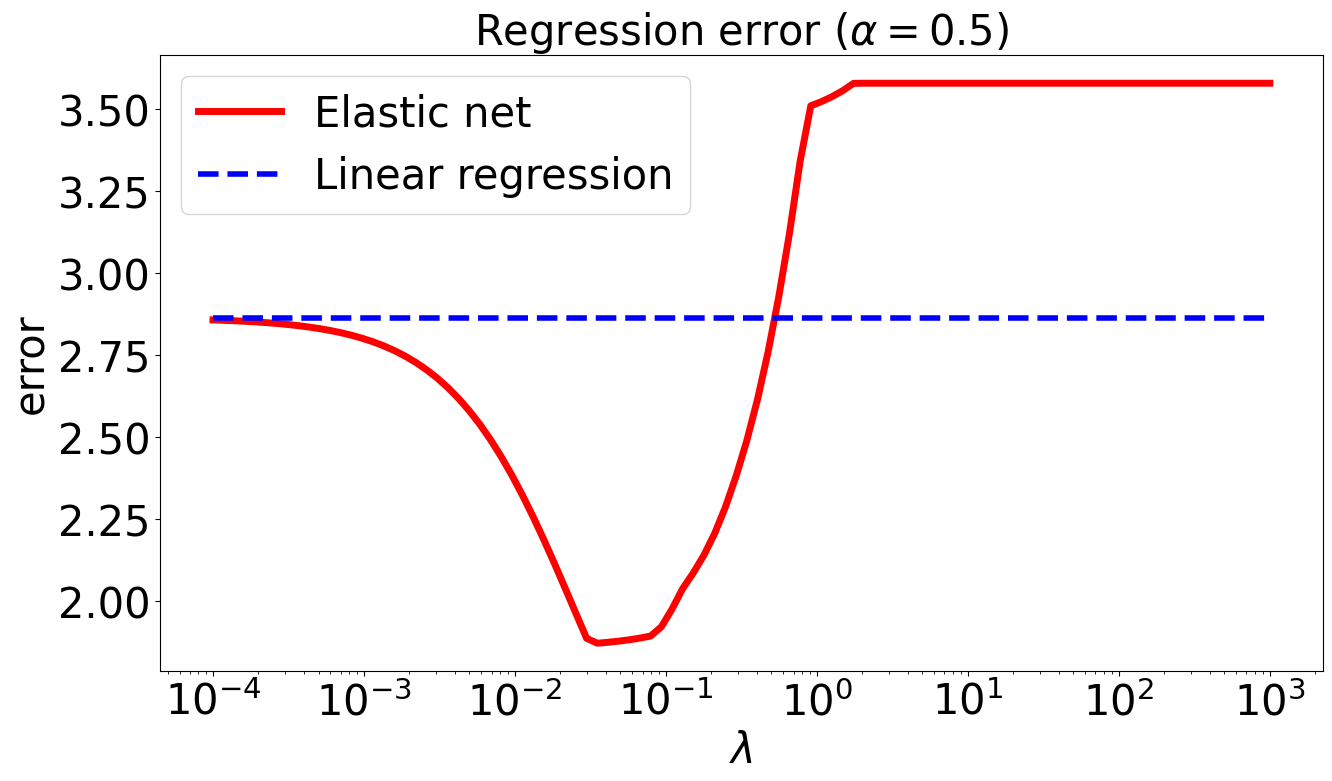

In [48]:
plt.figure(figsize=(15,8))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha=0.5$)', fontsize=30)
plt.show()

In [49]:
elastic_net = ElasticNet(alpha = 0.02, l1_ratio=1) #laratio=1 en realidad es aplicar LASO. Ya que se le da todo el peso
elastic_net.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


* El valor óptimo del coeficiente de regularización $\lambda$ está entre $10^{-2}$ y $10^{-1}$.
* Para $\lambda \to 0$, los términos de regularización desaparecen, lo que lleva al mismo resultado que la regresión lineal.
* Para $\lambda \to \infty$, el valor del término de regularización domina el error, que es menor que con *Lasso*.

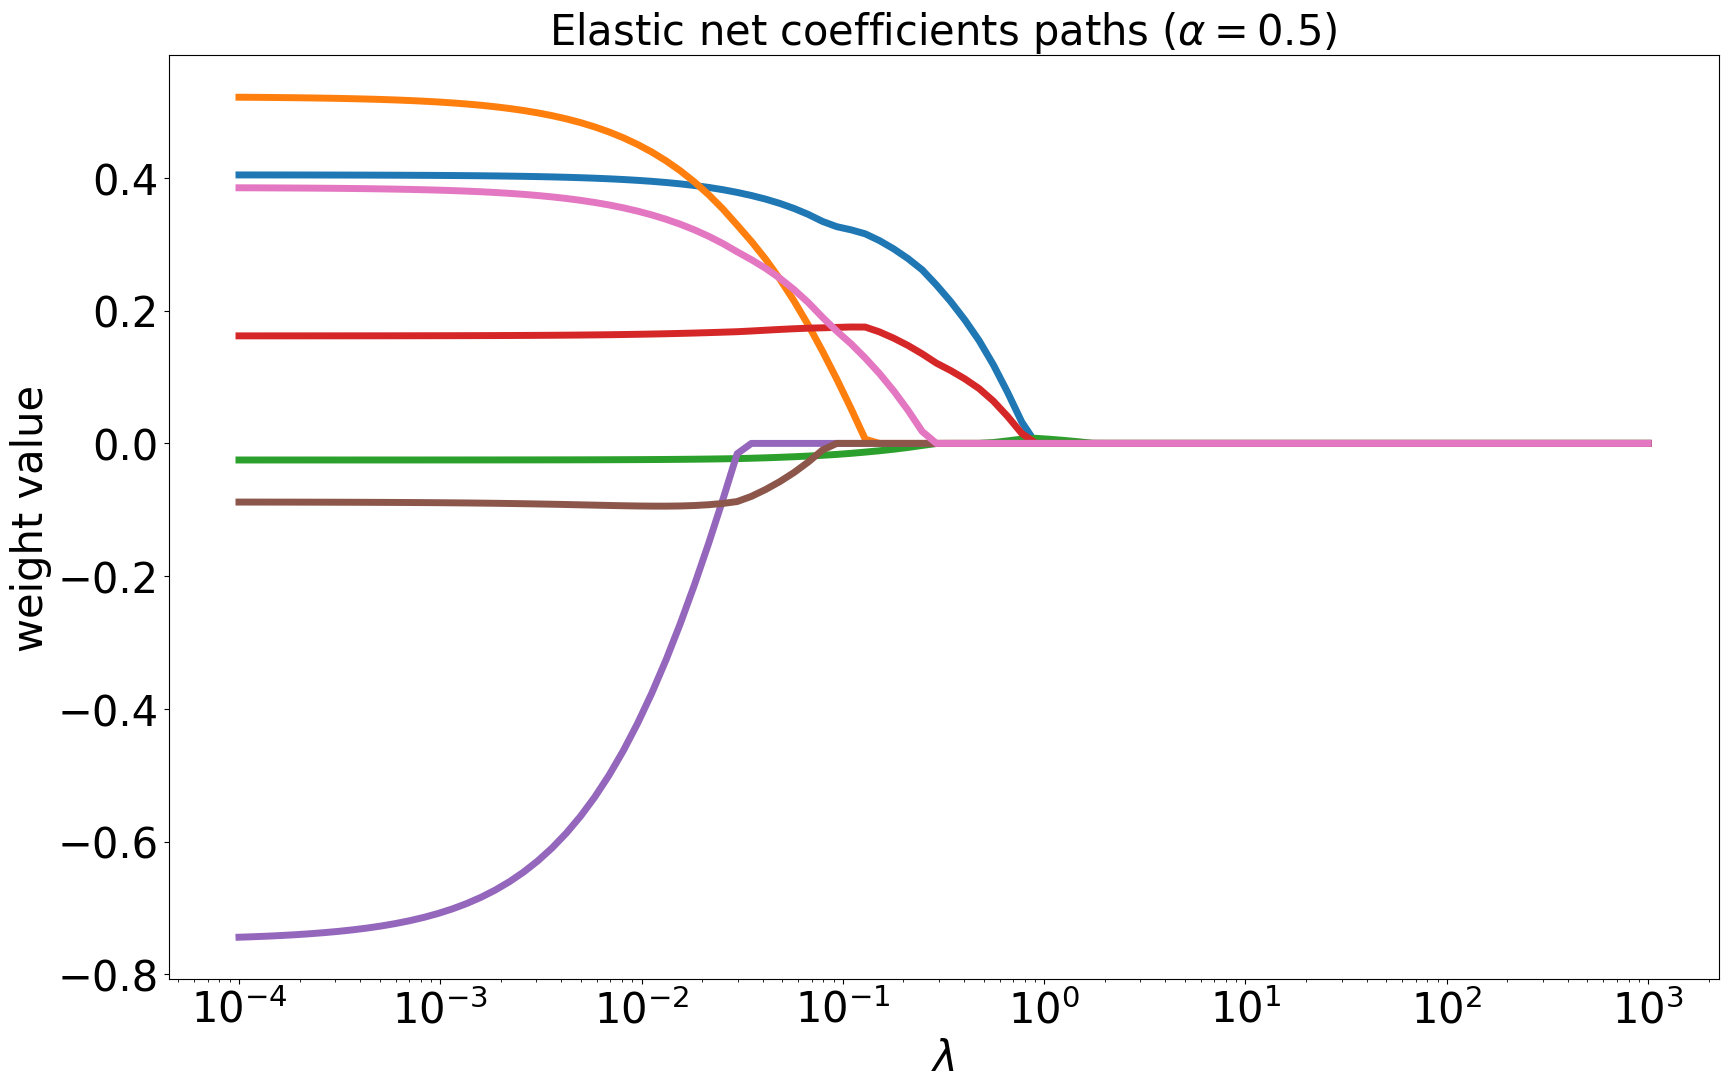

In [50]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=30)
plt.show()

* Como era de esperar el algoritmo *Elastic Net* mantiene más variables que el algoritmo *Lasso*.
* Se puede obtener un mejor rendimiento variando el valor del hiperparámetro $\alpha$.

# Selección de modelo 

In [52]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

Linear regression error:   2.8641
Minimun ridge error:       2.0651
Minimum lasso error:       1.8531
Minimum elastic net error: 1.8705


* El algoritmo *Lasso* funciona mejor que otros métodos (*Elastic Net*: $\alpha=0.5$).
* El modelo *Lasso* es más parsimonioso pero es probable que haya una pérdida de precisión.
* El algoritmo *Elastic Net* funciona mejor que la regresión *Ridge* (con $\alpha=0,5$).
* El algoritmo *Elastic Net* se puede ajustar para superar a *Lasso*, pero es más exigente en recursos computacionales.

**=> *Elastic Net* presenta un buen equilibrio entre la precisión y el coste computacional entre la regresión *Ridge* y *Lasso***.


Para optimizar el modelo ajustando los parámetros óptimos, se puede realizar una validación cruzada.
Las funciones ``sklearn.linear_model.RidgeCV``, ``sklearn.linear_model.LassoCV`` y ``sklearn.linear_model.ElasticNetCV`` en Python realizan un ajuste automático de hiperparámetros para la regresión *Rigde*, *Lasso* y *Elastic Net* respectivamente.